<a href="https://colab.research.google.com/github/Mohammad-Amirifard/Time-Series-Forecasting/blob/main/20231217_EDA_Sara.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Project Detail

**Problem:** Time Series Forecasting

**Goal:** The task is to develop a forecasting model that is able to predict several uncorrelated time series. The prerequisite is that the model exhibits generalisation capabilities in the forecasting domain, allowing it to transcend the constraints of specific time domains. This requires a model that, while specialised in forecasting, is not limited to predicting in a single or predefined time context.

**Dataset Detail:**


1.   Time series length: the length of the time series in the training dataset is variable. To simplify the portability of the dataset, we padded with zeros the sequences to the maximum length of 2776. Thus, the dataset is provided in a compact form as a Nx2776 array. We provide an additional 'valid_periods.npy' file containing the information to recover the original time series without the padding
2.   File Format: npy

3.   Categories: the provided time series are composed by sequences collected from 6 different sources. We further provide additional information about the category of each time series.


**Datas Structure:** Single folder containing the following files:
1. 'training_data.npy': it contains a numpy array of shape (48000, 2776). 48000 time series of length 2776.
2. 'valid_periods.npy': it contains a numpy array of type (48000, 2) containing for each of the time series the start and end index of the current series, i.e. the part without padding.
3. 'categories.npy': it contains a numpy array of shape (48000,), containing for each of the time series the code of its category. The possible categories are in {'A', 'B', 'C', 'D', 'E', 'F'}.
`IMPORTANT:` This is a dataset consisting of monovariate time series, i.e. composed of a single feature, belonging to six different domains. The time series of each domain are not to be understood as closely related to each other, but only as collected from similar data sources.
What is required of you is therefore to build a model that is capable of generalising sufficiently to predict the future samples of the 60 time series of the test set. To download `**datset**`, click on the link below: [link](https://drive.google.com/drive/folders/1LntbkzHK04CtRrXl8s9U62FH6V2VFkce?usp=sharing) and for `**github repositoy**` please click on this: [Link](https://github.com/Mohammad-Amirifard/Time-Series-Forecasting)

**Notebook 1:** In this notebook we are trying to do the first analyses on datas. Notebook 2 is dedicated for model choesed based on problem.

###1- Connect Colab to Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive') # mount google drive to /content directory. You can see your drive on the left pannel.

Mounted at /content/drive


In [2]:
# Copy  Project to /content direcory. Please replace project_directory with yours.
project_directory = "/content/drive/MyDrive/training_dataset.zip"
%cp -r {project_directory} /content

cp: cannot stat '/content/drive/MyDrive/training_dataset.zip': No such file or directory


###2- Import Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import GRU, Dense
%matplotlib inline

###3- Load data

In [4]:
# Unzip dataset to /content direcory. Please replace the dataset_dir with yours in you drive.
# !unzip -qq '/content/training_dataset.zip' -d '/content'

unzip:  cannot find or open /content/training_dataset.zip, /content/training_dataset.zip.zip or /content/training_dataset.zip.ZIP.


In [6]:
# categories = np.load('/content/categories.npy')
# training_data = np.load('/content/training_data.npy')
# valid_periods = np.load('/content/valid_periods.npy')

categories = np.load('/content/drive/MyDrive/Colab Notebooks/AN2DL-POLIMI/HW#2/training_dataset_AN2DL_Homework2/categories.npy')
training_data = np.load('/content/drive/MyDrive/Colab Notebooks/AN2DL-POLIMI/HW#2/training_dataset_AN2DL_Homework2/training_data.npy')
valid_periods = np.load('/content/drive/MyDrive/Colab Notebooks/AN2DL-POLIMI/HW#2/training_dataset_AN2DL_Homework2/valid_periods.npy')

### 4- EDA

####4-1 First info of Datasets

In [7]:
print(f'training_data.shape: {training_data.shape}')
print(f'categories.shape: {categories.shape}')
print(f'valid_periods.shape: {valid_periods.shape}')

training_data.shape: (48000, 2776)
categories.shape: (48000,)
valid_periods.shape: (48000, 2)


In [8]:
# Create Dataframe for each for better view
training_data_df = pd.DataFrame(training_data)
categories_df = pd.DataFrame(categories,columns=['Category'])
valid_periods_df = pd.DataFrame(valid_periods,columns=['Start index','End index'])

training_data_without_padding = []
for i, (start, end) in enumerate(valid_periods):
    training_data_without_padding.append(training_data[i, start:end])

In [9]:
training_data_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2766,2767,2768,2769,2770,2771,2772,2773,2774,2775
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.478704,0.412963,0.501852,0.756481,0.744444,0.640741,0.516667,0.602778,0.367593,0.331481
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.628000,0.624000,0.644000,0.688000,0.740000,0.640000,0.536000,0.600000,0.460000,0.396000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.959741,0.949098,0.919297,0.916705,0.901249,0.932531,0.955206,0.960481,0.946506,0.977140
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.411765,0.307030,0.325681,0.361549,0.430416,0.486370,0.450502,0.470588,0.569584,0.571019
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.340909,0.522727,0.568182,0.772727,0.681818,0.704545,0.863636,0.727273,0.818182,0.840909


In [10]:
categories_df.head()

,Category
0,D
1,D
2,D
3,D
4,D


In [11]:
valid_periods_df.head()

,Start index,End index
0,2325,2776
1,2325,2776
2,2325,2776
3,2712,2776
4,2682,2776


####4-2 Plot Function

In [12]:
# Here we show just only 5 time series together.
def plot_graphs(no_graphs=5,row_start_from = 0,show_outliers = False, upper_outliers = None, lower_outliers=None):

  figure = plt.figure(figsize=(15,7))

  for i in range(no_graphs):

    # Find start and end points of ith time series from valid_perods_df
    start_point = valid_periods_df.iloc[row_start_from + i,0]
    end_point = valid_periods_df.iloc[row_start_from + i,1]
    sns.lineplot(x=np.arange(start_point,end_point), y=training_data_df.iloc[row_start_from + i,start_point:end_point], label=f'time_series_{row_start_from + i}_With_Category_{list(categories_df.iloc[row_start_from + i])[0]}')
    # pay attention : lineplot for large range automatically performs data sampling to improve visualization performance.Hence, maybe you see some outliers are out of lines. But actually they are avaiable.
  if show_outliers :
    if upper_outliers is None:
      plt.scatter(x = lower_outliers.index, y = lower_outliers.values,color='green',label='lower_Outliers')
    elif lower_outliers is None:
      plt.scatter(x = upper_outliers.index, y = upper_outliers.values,color='red',label='upper_Outliers')
    else:
      plt.scatter(x = lower_outliers.index, y = lower_outliers.values,color='green',label='lower_Outliers')
      plt.scatter(x = upper_outliers.index, y = upper_outliers.values,color='red',label='upper_Outliers')

  plt.xlabel('Time')
  plt.ylabel('Value')
  plt.legend()
  plt.title(f'Line graph')
  plt.show()


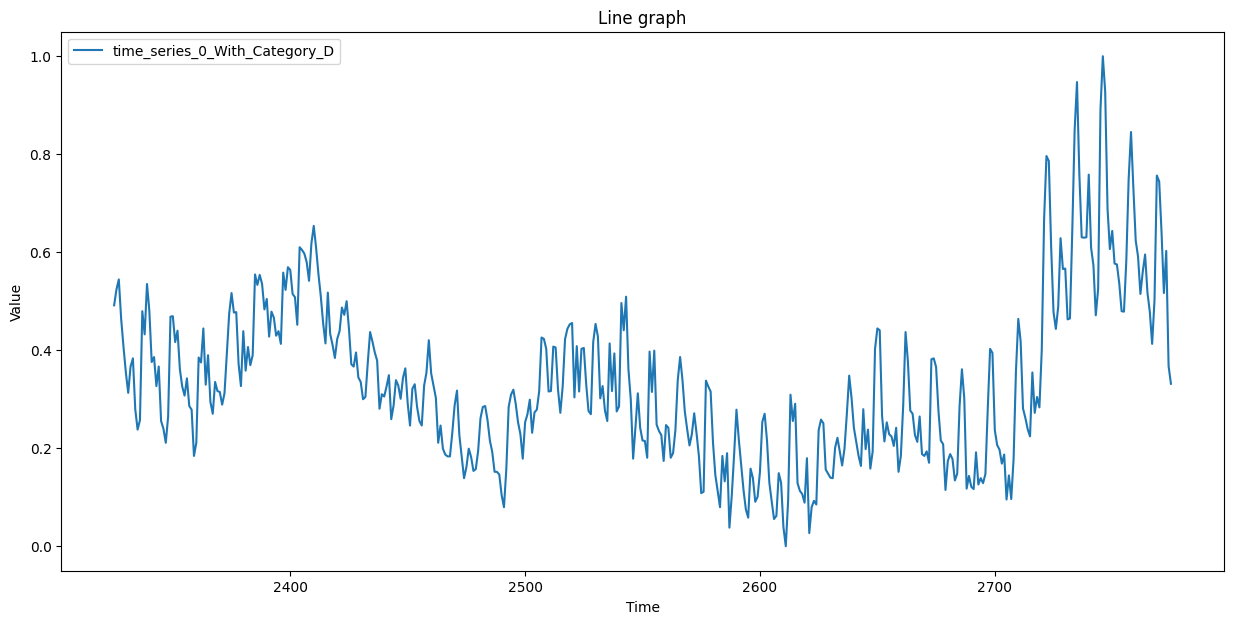

In [13]:
plot_graphs(no_graphs=1,row_start_from=0)

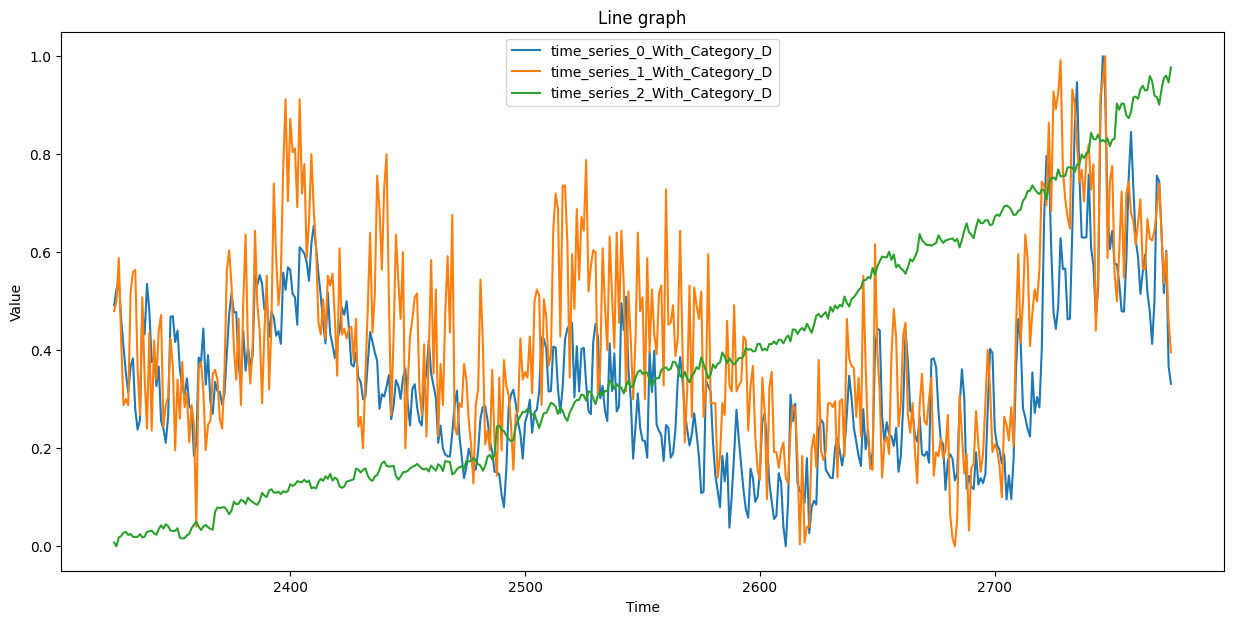

In [14]:
# Another plot for three grpahs
plot_graphs(no_graphs=3,row_start_from=0)

####4-3 Checkoutliers

In [15]:

def checkoutliers ():

  upper_outliers_dict = {}
  lower_outliers_dict = {}
  for row_no in range(training_data_df.shape[0]):

    start_point = valid_periods_df.iloc[row_no,0]
    end_point = valid_periods_df.iloc[row_no,1]
    statistical_info = training_data_df.iloc[row_no,start_point:end_point].describe()
    count = int(statistical_info[0])
    mean =statistical_info[1]
    std = statistical_info[2]
    Q1 = statistical_info[4]
    Q3 = statistical_info[6]

    # Using this rowle for finding outliers
    IQR = Q3-Q1
    lower_bound = Q1 - (1.5*IQR)
    upper_bound = Q3 + (1.5*IQR)

    upper_outliers_index = np.where(training_data_df.iloc[row_no,start_point:end_point]>upper_bound)+start_point
    upper_outliers_index = upper_outliers_index[0]
    upper_outliers = training_data_df.iloc[row_no,upper_outliers_index]

    if upper_outliers.shape[0]>0:
      upper_outliers_dict[f'{row_no}'] = upper_outliers
    else:
      pass

    lower_outliers_index = np.where(training_data_df.iloc[row_no,start_point:end_point]<lower_bound)+start_point
    lower_outliers_index = lower_outliers_index[0]
    lower_outliers = training_data_df.iloc[row_no,lower_outliers_index]

    if lower_outliers.shape[0]>0:
      lower_outliers_dict[f'{row_no}'] = lower_outliers
    else:
      pass

  return upper_outliers_dict, lower_outliers_dict

In [16]:
# upper_outliers_dict,lower_outliers_dict = checkoutliers()

####4-4 Plot graphs with outliers

In [17]:
# Plot graphs with outliers
def plot_outliers(row_no_to_show = 84):
  try:

    row_no_to_show = row_no_to_show # chose another number in outliers_dict to see outliers in different rows
    start_point = valid_periods_df.iloc[row_no_to_show,0]
    end_point = valid_periods_df.iloc[row_no_to_show,1]
    data_to_show = training_data_df.iloc[row_no_to_show,start_point:end_point]

    if f'{row_no_to_show}' in upper_outliers_dict:
      upper_outliers = upper_outliers_dict[f'{row_no_to_show}']
    else:
      upper_outliers = None

    if f'{row_no_to_show}' in lower_outliers_dict:
      lower_outliers = lower_outliers_dict[f'{row_no_to_show}']
    else:
      lower_outliers = None

    plot_graphs(no_graphs=1,row_start_from =row_no_to_show,
                show_outliers=True, upper_outliers=upper_outliers,
                lower_outliers=lower_outliers)

    plt.boxplot(x=data_to_show)
    plt.show()

  except:
    print('The row number you entered does not have outliers. Try another one.')
    print('You can chosse from lists below.')
    print(upper_outliers_dict.keys())
    print(f'or {lower_outliers_dict.keys()}')



In [19]:
# plot_outliers(row_no_to_show=84) # You can change this number to see others

#### 4-5 Replace Outliers with appropriate values.

In [ ]:
# Now, we skip this part to make a model and compare results with outliers and without them.

####4-6 Change dtype for easier computations

In [20]:
training_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48000 entries, 0 to 47999
Columns: 2776 entries, 0 to 2775
dtypes: float64(2776)
memory usage: 1016.6 MB


In [21]:
training_data_df = training_data_df.astype(np.float16)
training_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48000 entries, 0 to 47999
Columns: 2776 entries, 0 to 2775
dtypes: float16(2776)
memory usage: 254.2 MB


###5- Build_Sequence

In [22]:
def build_sequences(original_dataset, integer_labels, valid_periods, window=50, stride=25, telescope=9):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    predictions = []
    labels = []
    for i, row in enumerate(original_dataset):
        padding_len = window - len(original_dataset[i])%window
        original_dataset[i] = np.pad(original_dataset[i], (padding_len, 0), mode='constant', constant_values=0)
        for idx in np.arange(0,len(original_dataset[i])-window-telescope,stride):
            dataset.append(original_dataset[i][idx:idx+window].reshape((window, 1)))
            predictions.append(original_dataset[i][idx+window:idx+window+telescope].reshape((telescope, 1)))
            labels.append(integer_labels[i])
    dataset = np.array(dataset)
    predictions = np.array(predictions)
    labels = np.array(labels)
    return dataset, predictions, labels

In [23]:
X_train, y_train, labels = build_sequences(training_data_without_padding, categories, valid_periods, window=50, stride=25, telescope=9)
X_train.shape ,  y_train.shape, labels.shape

((338804, 50, 1), (338804, 9, 1), (338804,))

In [24]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 128
epochs = 200

In [25]:
print('x_train.shape:',X_train.shape, 'y_train.shape:',y_train.shape)
print(f'input_shape:{input_shape} and output_shape:{output_shape}')

x_train.shape: (338804, 50, 1) y_train.shape: (338804, 9, 1)
input_shape:(50, 1) and output_shape:(9, 1)


###6- Model Number 1

####6-1 Define Model

In [26]:
def build_CONV_LSTM_model(input_shape, output_shape):
    # Ensure the input time steps are at least as many as the output time steps
    assert input_shape[0] >= output_shape[0], "For this exercise we want input time steps to be >= of output time steps"

    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Add a Bidirectional LSTM layer with 64 units
    x = tfkl.Bidirectional(tfkl.LSTM(64, return_sequences=True, name='lstm'), name='bidirectional_lstm')(input_layer)

    # Add a 1D Convolution layer with 128 filters and a kernel size of 3
    x = tfkl.Conv1D(128, 3, padding='same', activation='relu', name='conv')(x)

    # Add a final Convolution layer to match the desired output shape
    output_layer = tfkl.Conv1D(output_shape[1], 3, padding='same', name='output_layer')(x)

    # Calculate the size to crop from the output to match the output shape
    crop_size = output_layer.shape[1] - output_shape[0]

    # Crop the output to the desired length
    output_layer = tfkl.Cropping1D((0, crop_size), name='cropping')(output_layer)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

    return model

Model: "CONV_LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 50, 1)]           0         
                                                                 
 bidirectional_lstm (Bidire  (None, 50, 128)           33792     
 ctional)                                                        
                                                                 
 conv (Conv1D)               (None, 50, 128)           49280     
                                                                 
 output_layer (Conv1D)       (None, 50, 1)             385       
                                                                 
 cropping (Cropping1D)       (None, 9, 1)              0         
                                                                 
Total params: 83457 (326.00 KB)
Trainable params: 83457 (326.00 KB)
Non-trainable params: 0 (0.00 Byte)
_____________

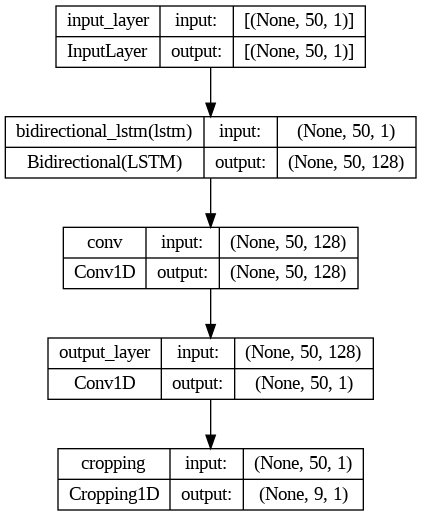

In [27]:
model = build_CONV_LSTM_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

####6-2 Fit Model

In [29]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = 50,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=12, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-5)
    ]
).history

Epoch 1/50
2383/2383 [==============================] - 23s 9ms/step - loss: 0.0088 - val_loss: 0.0131 - lr: 0.0010
Epoch 2/50
2383/2383 [==============================] - 21s 9ms/step - loss: 0.0088 - val_loss: 0.0130 - lr: 0.0010
Epoch 3/50
2383/2383 [==============================] - 23s 9ms/step - loss: 0.0088 - val_loss: 0.0129 - lr: 0.0010
Epoch 4/50
2383/2383 [==============================] - 21s 9ms/step - loss: 0.0088 - val_loss: 0.0130 - lr: 0.0010
Epoch 5/50
2383/2383 [==============================] - 23s 10ms/step - loss: 0.0087 - val_loss: 0.0128 - lr: 0.0010
Epoch 6/50
2383/2383 [==============================] - 21s 9ms/step - loss: 0.0087 - val_loss: 0.0129 - lr: 0.0010
Epoch 7/50
2383/2383 [==============================] - 22s 9ms/step - loss: 0.0087 - val_loss: 0.0129 - lr: 0.0010
Epoch 8/50
2383/2383 [==============================] - 21s 9ms/step - loss: 0.0087 - val_loss: 0.0129 - lr: 0.0010
Epoch 9/50
2383/2383 [==============================] - 22s 9ms/step - 

####6-3 Save Model

In [30]:
model.save('/content/1st_model')

In [31]:
!cp -r /content/1st_model /content/drive/MyDrive/

In [42]:
def build_model2(input_shape, output_shape):
    # Ensure the input time steps are at least as many as the output time steps
    assert input_shape[0] >= output_shape[0], "For this exercise we want input time steps to be >= of output time steps"

    # Define the input layer with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Add a Bidirectional LSTM layer with 64 units
    x = tfkl.Bidirectional(tfkl.LSTM(32, return_sequences=True, name='lstm'), name='bidirectional_lstm')(input_layer)

    # Add another LSTM layer with 32 units
    x = tfkl.LSTM(64, return_sequences=True, name='lstm2')(x)

    # Add a 1D Convolution layer with 128 filters and a kernel size of 3
    x = tfkl.Conv1D(128, 3, padding='same', activation='relu', name='conv')(x)

    # Add a final Convolution layer to match the desired output shape
    output_layer = tfkl.Conv1D(output_shape[1], 3, padding='same', name='output_layer')(x)

    # Calculate the size to crop from the output to match the output shape
    crop_size = output_layer.shape[1] - output_shape[0]

    # Crop the output to the desired length
    output_layer = tfkl.Cropping1D((0, crop_size), name='cropping')(output_layer)

    # Construct the model by connecting input and output layers
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model')

    # Compile the model with Mean Squared Error loss and Adam optimizer
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

    return model

Model: "CONV_LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 50, 1)]           0         
                                                                 
 bidirectional_lstm (Bidire  (None, 50, 64)            8704      
 ctional)                                                        
                                                                 
 lstm2 (LSTM)                (None, 50, 64)            33024     
                                                                 
 conv (Conv1D)               (None, 50, 128)           24704     
                                                                 
 output_layer (Conv1D)       (None, 50, 1)             385       
                                                                 
 cropping (Cropping1D)       (None, 9, 1)              0         
                                                   

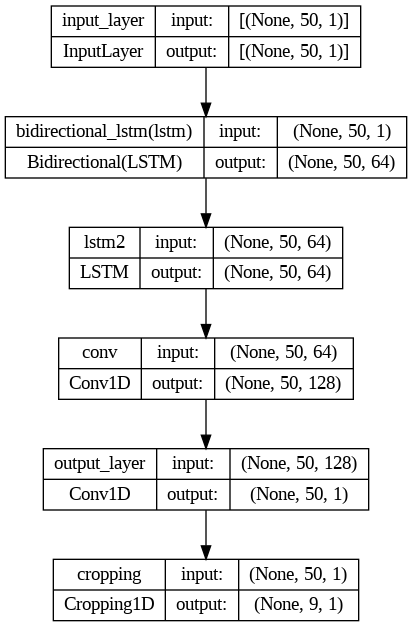

In [43]:
model2 = build_model2(input_shape, output_shape)
model2.summary()
tfk.utils.plot_model(model2, expand_nested=True, show_shapes=True)

####6-2 Fit Model

In [ ]:
# Train the model
history = model2.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = 50,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=12, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.1, min_lr=1e-5)
    ]
).history

Epoch 1/50
2383/2383 [==============================] - 35s 12ms/step - loss: 0.0183 - val_loss: 0.0172 - lr: 0.0010
Epoch 2/50
2383/2383 [==============================] - 29s 12ms/step - loss: 0.0132 - val_loss: 0.0165 - lr: 0.0010
Epoch 3/50
2383/2383 [==============================] - 30s 13ms/step - loss: 0.0124 - val_loss: 0.0166 - lr: 0.0010
Epoch 4/50
2383/2383 [==============================] - 29s 12ms/step - loss: 0.0120 - val_loss: 0.0159 - lr: 0.0010
Epoch 5/50
2383/2383 [==============================] - 31s 13ms/step - loss: 0.0118 - val_loss: 0.0160 - lr: 0.0010
Epoch 6/50
2383/2383 [==============================] - 28s 12ms/step - loss: 0.0116 - val_loss: 0.0152 - lr: 0.0010
Epoch 7/50
2383/2383 [==============================] - 29s 12ms/step - loss: 0.0113 - val_loss: 0.0149 - lr: 0.0010
Epoch 8/50
2383/2383 [==============================] - 30s 12ms/step - loss: 0.0108 - val_loss: 0.0145 - lr: 0.0010
Epoch 9/50
2383/2383 [==============================] - 29s 12ms

####6-3 Save Model

In [ ]:
model.save('/content/1st_model')

In [ ]:
!cp -r /content/1st_model /content/drive/MyDrive/